In [1]:
%matplotlib inline

import matplotlib
# matplotlib.use('pgf')
# pgf_with_rc_fonts = {
#     "font.family": "serif",
#     "font.serif": [],                   # use latex default serif font
#     "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
#     "pgf.rcfonts" : False
# }
# matplotlib.rcParams.update(pgf_with_rc_fonts)

from matplotlib import rc
import matplotlib.pyplot as plt

import scipy.stats as st
import numpy as np
import json

import sys
sys.path.append("/home/joshua/Documents/Uni/Year4/dissertation/catkin_ws/src/linefollow_gazebo/scripts")

import helper as h
from CameraModel import Camera
from RoadModel import Road, NormalProbabilityDist
from Path import Path

plt.style.use('ggplot')
from matplotlib import rc

rc('text', usetex=True)
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = '0.4'
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['grid.color'] = "0.9"

plt.tight_layout(.5)


# Single Camera

All analysis here is conducted with a simpler objective function: maximizing ( expected improvement in location uncertainty).
    
This directly related to the kalman gain: as measurement noise -> 0, kalmain gain -> 1 and the measurement is taken as more as better truth estimator. If measurement noise is very large, kalman gain -> 0 and measurement is ignored. We obtain the best reduction in KF covariance by therefore maximizing the kalman gain, or minimizing measurement noise.
    
Therefore, the goal of maximizing expected localization uncertainty improvement is equivalent to minimizing expected measurement noise R_k. Across the pixel plane therefore, we can use the sum(prob of vehicle center being in pixel * measurement error at that pixel)

In [2]:
# will use the same probability distribution across all experiments
road_prob_dist = NormalProbabilityDist(two_stddev=0.4) # vehicles will 95% of time be +-0.4 meter of center of road
#
resolution = (300,300)

In [4]:
def get_predicted_error_radius(camera_height,
                               ground_distance, 
                               pixel_area,
                               sigma_pos=0.03/2.0,
                               sigma_orient_deg=0.5/2,
                               alg_error=4.0, # note: changed
                               verbose=False,
                               orientation_percent=0.9,
                               pos_percent=0.9,
                               alg_percent=0.9,
                               use_err_xy=True,
                               use_err_z=True,
                               use_err_orient=True,
                               use_err_pixel=True
                              ):
    # TODO this is wrong implementation! Doesn't matter though really as long as use is consistent
    # but really it should be -1*norm.ppf((1-percent)/2.0)
    # as it is is an underestimate

    stddevs_orientation = st.norm.ppf(orientation_percent)
    stddevs_position = st.norm.ppf(pos_percent)
    stddevs_alg = st.norm.ppf(alg_percent)
    
    
    # NOT invariant between pixels
    z_error = (ground_distance/camera_height)*stddevs_position*sigma_pos if use_err_z else 0
    
    # NOT invariant between pixels
    if use_err_orient:
        t = stddevs_orientation*np.deg2rad(sigma_orient_deg)
        alpha = np.arctan2(ground_distance, camera_height)
        beta = alpha + t
        if beta > np.pi/2: # causes tan to roll over into negatives...
            orientation_error = 9999999999
        else:
            orientation_error = np.tan(beta)*camera_height - ground_distance
    else:
        orientation_error = 0
    
    pixel_error = np.sqrt(2*pixel_area) if use_err_pixel else 0
    
#     print("Z error: {0}".format(z_error))
#     print("orien error: {0}".format(orientation_error))
#     print("pixel_error: {0}".format(pixel_error))
    total = z_error + orientation_error + (alg_error+1)/2.0 * stddevs_alg * pixel_error
    return total, z_error, orientation_error, alg_error*pixel_error

In [5]:
def error_radius_across_pixels(camera):
    
    image = np.zeros(shape=(camera.R_y, camera.R_x+1)) # add one because using pixel as bottom left corner! Symmetry matters here
    camera_x, camera_y, camera_z = camera.position
    camera_ground_pos = np.array([camera_x, camera_y, 0.0])

    for (y,x), _ in np.ndenumerate(image):

        ground_point = camera.pixel_to_plane(x, y)
        pixel_area = camera.plane_area_of_pixel(x,y)

        if ground_point is None or pixel_area is None:
            image[y, x] = 999999999999
            continue

        ground_distance = np.linalg.norm(ground_point - camera_ground_pos)

        image[y, x] = get_predicted_error_radius(camera_z, ground_distance, pixel_area)[0]

        return image
        

## Straight Road

Constant FOV of 60 deg, and fix resolution at 300x300

In [6]:
camera_height = 6.0
resolution = (20, 20)
fov_deg = (60.0, 60.0)
yaw_range = 90 # degrees +- from center yaw position

curvature = 0.0
length = 40.0 # needs to be long enough to exceed camera view at 0 and 180 deg yaw!

path = Path()
path.add_segment(curvature, length)
road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

# place camera halfway along road
allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
lhs_pos, lhs_direction = allowed_positions_orientations[0]
rhs_pos, rhs_direction = allowed_positions_orientations[1]

# just stick with lhs for now, symmetric with straight road

camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
camera_pitches = np.arange(31.0, 92.0, 3)

# convert lhs_direction into a yaw facing the road perpendicularly
center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
center_yaw_deg = np.rad2deg(center_yaw_rad)
camera_yaws = np.arange(center_yaw_deg - yaw_range, center_yaw_deg + yaw_range + 10, 10.0)


In [7]:

scores = np.zeros(shape=(camera_pitches.shape[0], camera_yaws.shape[0]))
for j, yaw in enumerate(camera_yaws):
    for i, pitch in enumerate(camera_pitches):
        print("Processing: pitch -- {0}, yaw -- {1}".format(pitch, yaw))
        name = "pitch_{0}_yaw_{1}".format(pitch, yaw)
        camera = Camera(camera_position, pitch, yaw)
        camera.set_resolution(*resolution)
        camera.set_fov(*fov_deg)

        pixel_probabilities = camera.get_pixel_probabilities_for_road(road)
        
        # didn't want any pyplot stuff running
        # in case of leaking memory from open figures that I don't quite understand
        
#         plt.imshow(pixel_probabilities)
#         plt.gray()
#         plt.imsave(save_dir + name + "_road_probabilities.png")
#         plt.cla()
#         plt.clf()
        
        
        # calculate error radius at each pixel
        error_bounds = error_radius_across_pixels(camera)
#         plt.imshow(error_bounds)
#         plt.gray()
#         plt.imsave(save_dir + name + "_error_bounds.png")
        
        target = (1.0/(1+error_bounds**2)) * pixel_probabilities
#         plt.imshow(product)
#         plt.gray()
#         plt.imsave(save_dir + name + "_product.png")
        # take the sum => now have an expected value!
        
        score = np.sum(target)
        print("Score: {0}".format(score))
        scores[i, j] = score

Processing: pitch -- 31.0, yaw -- 0.0
Score: 0.056835397979
Processing: pitch -- 34.0, yaw -- 0.0
Score: 0.0618600466857
Processing: pitch -- 37.0, yaw -- 0.0
Score: 0.0670219553381
Processing: pitch -- 40.0, yaw -- 0.0
Score: 0.0724033192513
Processing: pitch -- 43.0, yaw -- 0.0
Score: 0.0777523656362
Processing: pitch -- 46.0, yaw -- 0.0
Score: 0.0825072372718
Processing: pitch -- 49.0, yaw -- 0.0
Score: 0.0849443129748
Processing: pitch -- 52.0, yaw -- 0.0
Score: 0.0891782535443
Processing: pitch -- 55.0, yaw -- 0.0
Score: 0.0911539142947
Processing: pitch -- 58.0, yaw -- 0.0
Score: 0.0950995045427
Processing: pitch -- 61.0, yaw -- 0.0
Score: 0.0968767754102
Processing: pitch -- 64.0, yaw -- 0.0
Score: 0.100281650958
Processing: pitch -- 67.0, yaw -- 0.0
Score: 0.102339032357
Processing: pitch -- 70.0, yaw -- 0.0
Score: 0.104902222361
Processing: pitch -- 73.0, yaw -- 0.0
Score: 0.107322769674
Processing: pitch -- 76.0, yaw -- 0.0
Score: 0.109174153676
Processing: pitch -- 79.0, yaw

Score: 0.106677954418
Processing: pitch -- 55.0, yaw -- 60.0
Score: 0.10535301636
Processing: pitch -- 58.0, yaw -- 60.0
Score: 0.104657655615
Processing: pitch -- 61.0, yaw -- 60.0
Score: 0.10460384027
Processing: pitch -- 64.0, yaw -- 60.0
Score: 0.105141980836
Processing: pitch -- 67.0, yaw -- 60.0
Score: 0.106251628504
Processing: pitch -- 70.0, yaw -- 60.0
Score: 0.107944612042
Processing: pitch -- 73.0, yaw -- 60.0
Score: 0.109493914296
Processing: pitch -- 76.0, yaw -- 60.0
Score: 0.104387058912
Processing: pitch -- 79.0, yaw -- 60.0
Score: 0.0969693627077
Processing: pitch -- 82.0, yaw -- 60.0
Score: 0.0889459650036
Processing: pitch -- 85.0, yaw -- 60.0
Score: 0.0802457970214
Processing: pitch -- 88.0, yaw -- 60.0
Score: 0.0707706468981
Processing: pitch -- 91.0, yaw -- 60.0
Score: 0.0604027842999
Processing: pitch -- 31.0, yaw -- 70.0
Score: 0.0630181257502
Processing: pitch -- 34.0, yaw -- 70.0
Score: 0.0804403858206
Processing: pitch -- 37.0, yaw -- 70.0
Score: 0.0971409057

Score: 0.104387058912
Processing: pitch -- 79.0, yaw -- 120.0
Score: 0.0969693627077
Processing: pitch -- 82.0, yaw -- 120.0
Score: 0.0889459650036
Processing: pitch -- 85.0, yaw -- 120.0
Score: 0.0802457970214
Processing: pitch -- 88.0, yaw -- 120.0
Score: 0.0707706468981
Processing: pitch -- 91.0, yaw -- 120.0
Score: 0.0604027842999
Processing: pitch -- 31.0, yaw -- 130.0
Score: 0.071385253129
Processing: pitch -- 34.0, yaw -- 130.0
Score: 0.079053829454
Processing: pitch -- 37.0, yaw -- 130.0
Score: 0.0869907831535
Processing: pitch -- 40.0, yaw -- 130.0
Score: 0.0951508774623
Processing: pitch -- 43.0, yaw -- 130.0
Score: 0.103329991016
Processing: pitch -- 46.0, yaw -- 130.0
Score: 0.110292665965
Processing: pitch -- 49.0, yaw -- 130.0
Score: 0.112412995103
Processing: pitch -- 52.0, yaw -- 130.0
Score: 0.111368604884
Processing: pitch -- 55.0, yaw -- 130.0
Score: 0.1105413159
Processing: pitch -- 58.0, yaw -- 130.0
Score: 0.110454232611
Processing: pitch -- 61.0, yaw -- 130.0
Sco

In [6]:
# save above to file to not lose it! very expensive computation
np.save("V2_straight_road_40m_{0}x{1}0_6m_pitch_yaw_scores_0-4_two_stddev.npy".format(*resolution), scores)

In [20]:
# recover data
scores = np.load("V2_straight_road_40m_{0}x{1}0_6m_pitch_yaw_scores_0-4_two_stddev.npy".format(*resolution))

[ 20.  -3.   6.]


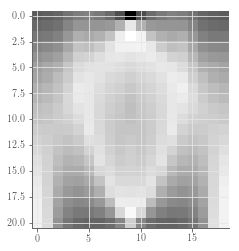

In [8]:
print(camera_position)
plt.imshow(scores)
plt.gray()
plt.show()

In [12]:
# get sorted indices
sorted_indices = np.array(np.unravel_index(np.argsort(scores, axis=None), scores.shape)).T
print(sorted_indices)


[[ 0  9]
 [ 0 10]
 [ 0  8]
 [ 0  0]
 [ 0 18]
 [ 0  1]
 [ 0 17]
 [20 13]
 [20  5]
 [20 12]
 [20  6]
 [ 0  2]
 [ 0 16]
 [ 1  0]
 [20  4]
 [20 14]
 [ 1 18]
 [ 0 11]
 [ 0  7]
 [ 1  1]
 [ 1 17]
 [20 11]
 [20  7]
 [ 1  2]
 [ 1 16]
 [ 0  3]
 [ 0 15]
 [ 2  0]
 [20 15]
 [20  3]
 [19 13]
 [19  5]
 [19 14]
 [19  4]
 [ 2 18]
 [ 0 12]
 [ 0  6]
 [ 2  1]
 [ 2 17]
 [ 0  4]
 [ 0 14]
 [19 12]
 [19  6]
 [ 2  2]
 [ 2 16]
 [ 0  5]
 [ 0 13]
 [19  3]
 [19 15]
 [ 3  0]
 [ 1  3]
 [ 1 15]
 [20  8]
 [20 10]
 [18 14]
 [18  4]
 [ 3 18]
 [ 3  1]
 [ 3 17]
 [18  5]
 [18 13]
 [18  3]
 [18 15]
 [ 3  2]
 [ 3 16]
 [ 4  0]
 [20  2]
 [20 16]
 [17  4]
 [17 14]
 [ 1  5]
 [ 1 13]
 [ 1  6]
 [ 1 12]
 [ 1  4]
 [ 1 14]
 [19  7]
 [19 11]
 [ 4 18]
 [ 2  3]
 [ 2 15]
 [18 12]
 [18  6]
 [ 4  1]
 [17  3]
 [17 15]
 [ 1  7]
 [ 1 11]
 [ 4 17]
 [17 13]
 [17  5]
 [19  2]
 [19 16]
 [ 5  0]
 [ 4  2]
 [ 4 16]
 [16  4]
 [16 14]
 [16  3]
 [16 15]
 [18  2]
 [18 16]
 [ 5 18]
 [ 6  0]
 [ 5  1]
 [ 3  3]
 [ 3 15]
 [ 2  5]
 [ 2 13]
 [ 5 17]
 [16  5]
 

Pitches: 
[ 31.  34.  37.  40.  43.  46.  49.  52.  55.  58.  61.  64.  67.  70.  73.
  76.  79.  82.  85.  88.  91.]
Yaws: 
[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.]
Score: 0.1124 -- Pitch: 49.0, Yaw: 130.0 (index 6, 13)


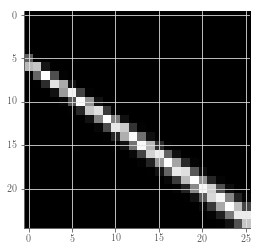

Score: 0.1129 -- Pitch: 82.0, Yaw: 0.0 (index 17, 0)


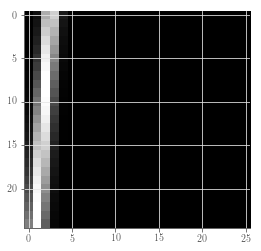

Score: 0.1129 -- Pitch: 85.0, Yaw: 100.0 (index 18, 10)


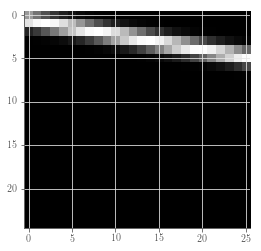

Score: 0.1129 -- Pitch: 85.0, Yaw: 80.0 (index 18, 8)


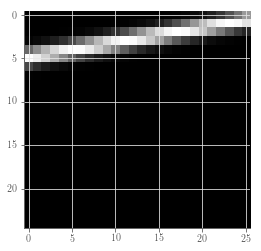

Score: 0.1130 -- Pitch: 37.0, Yaw: 80.0 (index 2, 8)


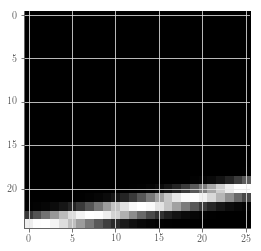

Score: 0.1131 -- Pitch: 79.0, Yaw: 180.0 (index 16, 18)


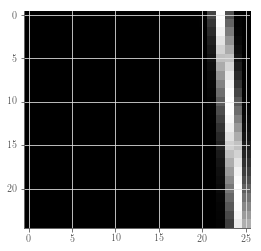

Score: 0.1138 -- Pitch: 85.0, Yaw: 0.0 (index 18, 0)


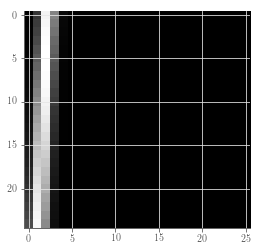

Score: 0.1139 -- Pitch: 52.0, Yaw: 140.0 (index 7, 14)


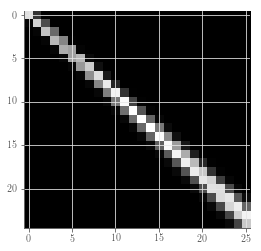

Score: 0.1142 -- Pitch: 82.0, Yaw: 180.0 (index 17, 18)


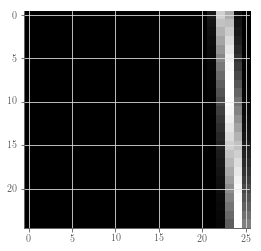

Score: 0.1143 -- Pitch: 40.0, Yaw: 90.0 (index 3, 9)


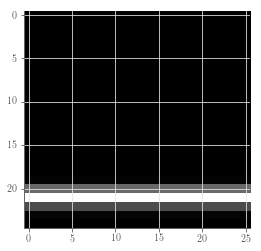

Score: 0.1144 -- Pitch: 40.0, Yaw: 80.0 (index 3, 8)


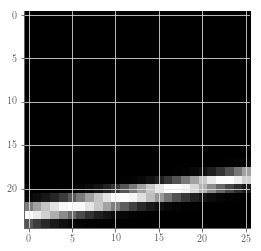

Score: 0.1144 -- Pitch: 88.0, Yaw: 0.0 (index 19, 0)


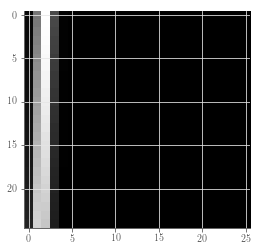

Score: 0.1145 -- Pitch: 91.0, Yaw: 0.0 (index 20, 0)


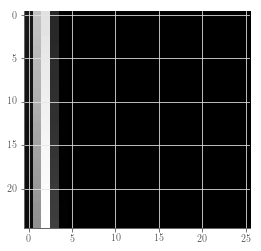

Score: 0.1147 -- Pitch: 91.0, Yaw: 180.0 (index 20, 18)


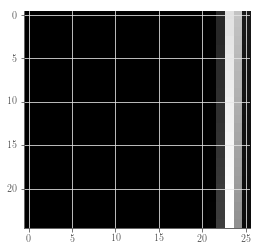

Score: 0.1147 -- Pitch: 85.0, Yaw: 180.0 (index 18, 18)


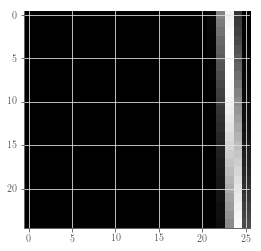

Score: 0.1148 -- Pitch: 88.0, Yaw: 180.0 (index 19, 18)


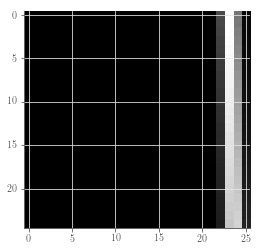

Score: 0.1153 -- Pitch: 40.0, Yaw: 100.0 (index 3, 10)


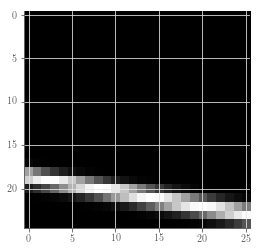

Score: 0.1156 -- Pitch: 37.0, Yaw: 100.0 (index 2, 10)


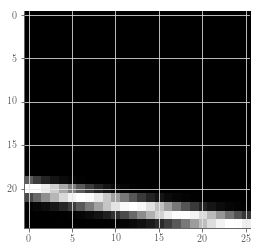

Score: 0.1173 -- Pitch: 88.0, Yaw: 90.0 (index 19, 9)


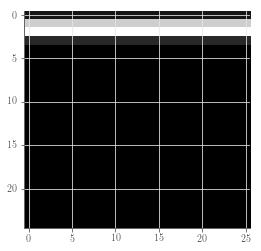

Score: 0.1199 -- Pitch: 37.0, Yaw: 90.0 (index 2, 9)


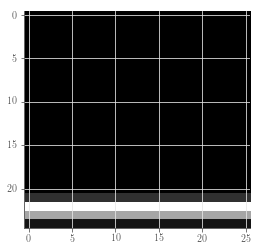

In [13]:
# look at the top 10 scores


print("Pitches: \n{0}".format(camera_pitches))
print("Yaws: \n{0}".format(camera_yaws))
for pitch_index, yaw_index in sorted_indices[-20:]:
    pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
    print("Score: {2:.4f} -- Pitch: {0}, Yaw: {1} (index {3}, {4})".format(pitch, yaw, scores[pitch_index, yaw_index], pitch_index, yaw_index))
    
    c = Camera(camera_position, pitch, yaw)
    c.set_resolution(25, 25)
    c.set_fov(*fov_deg)
    
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    plt.imshow(np.flip(pixel_probabilities, 0))
    plt.gray()
    plt.show()


In [11]:
"""
pitch_index, yaw_index= 2, 9
pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
print("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))
c = Camera(camera_position, pitch, yaw)
c.set_resolution(25, 25)
c.set_fov(*fov_deg)
pixel_probabilities = c.get_pixel_probabilities_for_road(road)
error_bounds = error_radius_across_pixels(c)
target = (1.0/(1+error_bounds)) * pixel_probabilities
score = np.sum(target)
print("Score: {0}".format(score))
plt.imshow(np.flip(pixel_probabilities, 0))
plt.gray()
plt.show()
"""

'\npitch_index, yaw_index= 2, 9\npitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]\nprint("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))\nc = Camera(camera_position, pitch, yaw)\nc.set_resolution(25, 25)\nc.set_fov(*fov_deg)\npixel_probabilities = c.get_pixel_probabilities_for_road(road)\nerror_bounds = error_radius_across_pixels(c)\ntarget = (1.0/(1+error_bounds)) * pixel_probabilities\nscore = np.sum(target)\nprint("Score: {0}".format(score))\nplt.imshow(np.flip(pixel_probabilities, 0))\nplt.gray()\nplt.show()\n'

In [11]:
"""
pitch_index, yaw_index = 7, 14
pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
print("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))
c = Camera(camera_position, pitch, yaw)
c.set_resolution(100, 100)
c.set_fov(*fov_deg)
pixel_probabilities = c.get_pixel_probabilities_for_road(road)
print("Sum pixel probabilities: {0}".format(np.sum(pixel_probabilities)))
error_bounds = error_radius_across_pixels(c)
print("Sum error bounds: {0}".format(np.sum(error_bounds)))
target = (1.0/(1+error_bounds)) * pixel_probabilities
score = np.sum(target)
print("Score: {0}".format(score))
plt.imshow(np.flip(pixel_probabilities, 0))
plt.gray()
plt.show()
"""

'\npitch_index, yaw_index = 7, 14\npitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]\nprint("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))\nc = Camera(camera_position, pitch, yaw)\nc.set_resolution(100, 100)\nc.set_fov(*fov_deg)\npixel_probabilities = c.get_pixel_probabilities_for_road(road)\nprint("Sum pixel probabilities: {0}".format(np.sum(pixel_probabilities)))\nerror_bounds = error_radius_across_pixels(c)\nprint("Sum error bounds: {0}".format(np.sum(error_bounds)))\ntarget = (1.0/(1+error_bounds)) * pixel_probabilities\nscore = np.sum(target)\nprint("Score: {0}".format(score))\nplt.imshow(np.flip(pixel_probabilities, 0))\nplt.gray()\nplt.show()\n'

In [12]:
"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scores_flat = scores.ravel()
ps, ys = np.meshgrid(camera_pitches, camera_yaws)
ps_, ys_ = ps.ravel(), ys.ravel()
bottom = np.zeros_like(ps_)
width = ps[0, 1] - ps[0,0]
depth = ys[0,0] - ys[1,0]
print(ps_.shape, ys_.shape, scores.ravel().shape)
print(width, depth)
ax.bar3d(ps_, ys_, bottom, width, depth, scores.ravel(), shade=True)
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nscores_flat = scores.ravel()\nps, ys = np.meshgrid(camera_pitches, camera_yaws)\nps_, ys_ = ps.ravel(), ys.ravel()\nbottom = np.zeros_like(ps_)\nwidth = ps[0, 1] - ps[0,0]\ndepth = ys[0,0] - ys[1,0]\nprint(ps_.shape, ys_.shape, scores.ravel().shape)\nprint(width, depth)\nax.bar3d(ps_, ys_, bottom, width, depth, scores.ravel(), shade=True)\nplt.show()\n"

In [13]:
"""
c2 = Camera(camera_position, 55, 25)
c2.set_resolution(200,200)
pixel_probabilities = c2.get_pixel_probabilities_for_road(road)
pitch = 55
for y in camera_yaws:
    print(y)
    c = Camera(camera_position, pitch, y)
    c.set_resolution(50, 50)
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    # flip the y axis for displaying as an image...
    
    plt.imshow(np.flip(pixel_probabilities, 0))
    plt.gray()
    plt.show()
"""

'\nc2 = Camera(camera_position, 55, 25)\nc2.set_resolution(200,200)\npixel_probabilities = c2.get_pixel_probabilities_for_road(road)\npitch = 55\nfor y in camera_yaws:\n    print(y)\n    c = Camera(camera_position, pitch, y)\n    c.set_resolution(50, 50)\n    pixel_probabilities = c.get_pixel_probabilities_for_road(road)\n    # flip the y axis for displaying as an image...\n    \n    plt.imshow(np.flip(pixel_probabilities, 0))\n    plt.gray()\n    plt.show()\n'

## Take into account Curvature
how to handle edge of roads? usually have an occlusion... 
* add a cylinder at the position the camera is located! => raytracer will intersect this

In [14]:
def plot_vector(axis, vec_start, vec_end):
    x,y,z =vec_start
    u,v,w = vec_end - vec_start
    axis.quiver(x,y,z,u,v,w)
def plot_points(axis, points):
    if points.shape[0] == 0:
        return
    axis.scatter(points[:, 0], points[:, 1], points[:, 2])

In [15]:
curvatures = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
# curvatures = [0.1]
curvature_score_maps = []
# separate cell => abort and can save partial results

---- Curvature: 0.001 ----
Cylinder radius: 997.0
Road radius: 1000.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 0.015590045016
Processing: pitch -- 34.0, yaw -- 180.0
Score: 0.0173123853032
Processing: pitch -- 37.0, yaw -- 180.0
Score: 0.0159061176076
Processing: pitch -- 40.0, yaw -- 180.0
Score: 0.016960652641
Processing: pitch -- 43.0, yaw -- 180.0
Score: 0.0183521854556
Processing: pitch -- 46.0, yaw -- 180.0
Score: 0.0192458705334
Processing: pitch -- 49.0, yaw -- 180.0
Score: 0.0215887533353
Processing: pitch -- 52.0, yaw -- 180.0
Score: 0.0200421989701
Processing: pitch -- 55.0, yaw -- 180.0
Score: 0.0208154219115
Processing: pitch -- 58.0, yaw -- 180.0
Score: 0.0227669902499
Processing: pitch -- 61.0, yaw -- 180.0
Score: 0.024709936163
Processing: pitch -- 64.0, yaw -- 180.0
Score: 0.0246186882408
Processing: pitch -- 67.0, yaw -- 180.0
Score: 0.0231501874961
Processing: pitch -- 70.0, yaw -- 180.0
Score: 0.0231692960306
Processing: pitch -- 73.0, yaw -- 180.0
Score: 0.02

Score: 0.0291465766675
Processing: pitch -- 52.0, yaw -- 240.0
Score: 0.0271744440736
Processing: pitch -- 55.0, yaw -- 240.0
Score: 0.0272276384907
Processing: pitch -- 58.0, yaw -- 240.0
Score: 0.0271558217001
Processing: pitch -- 61.0, yaw -- 240.0
Score: 0.0263672114243
Processing: pitch -- 64.0, yaw -- 240.0
Score: 0.0284479588589
Processing: pitch -- 67.0, yaw -- 240.0
Score: 0.0267949830491
Processing: pitch -- 70.0, yaw -- 240.0
Score: 0.0297465690551
Processing: pitch -- 73.0, yaw -- 240.0
Score: 0.0270975143725
Processing: pitch -- 76.0, yaw -- 240.0
Score: 0.0261288821117
Processing: pitch -- 79.0, yaw -- 240.0
Score: 0.0235264327806
Processing: pitch -- 82.0, yaw -- 240.0
Score: 0.0218193135062
Processing: pitch -- 85.0, yaw -- 240.0
Score: 0.0194532310193
Processing: pitch -- 88.0, yaw -- 240.0
Score: 0.0170838308648
Processing: pitch -- 91.0, yaw -- 240.0
Score: 0.0144916330211
Processing: pitch -- 31.0, yaw -- 250.0
Score: 0.0181032583723
Processing: pitch -- 34.0, yaw -

Score: 0.0297465690551
Processing: pitch -- 73.0, yaw -- 300.0
Score: 0.0270975143725
Processing: pitch -- 76.0, yaw -- 300.0
Score: 0.0261288821117
Processing: pitch -- 79.0, yaw -- 300.0
Score: 0.0235264327806
Processing: pitch -- 82.0, yaw -- 300.0
Score: 0.0218193135062
Processing: pitch -- 85.0, yaw -- 300.0
Score: 0.0194532310193
Processing: pitch -- 88.0, yaw -- 300.0
Score: 0.0170838308648
Processing: pitch -- 91.0, yaw -- 300.0
Score: 0.0144916330211
Processing: pitch -- 31.0, yaw -- 310.0
Score: 0.0208235130109
Processing: pitch -- 34.0, yaw -- 310.0
Score: 0.0205069501182
Processing: pitch -- 37.0, yaw -- 310.0
Score: 0.0236423075779
Processing: pitch -- 40.0, yaw -- 310.0
Score: 0.0258567935511
Processing: pitch -- 43.0, yaw -- 310.0
Score: 0.0268171597737
Processing: pitch -- 46.0, yaw -- 310.0
Score: 0.0307364243221
Processing: pitch -- 49.0, yaw -- 310.0
Score: 0.0285347781503
Processing: pitch -- 52.0, yaw -- 310.0
Score: 0.0300809221684
Processing: pitch -- 55.0, yaw -

Score: 0.0232018356768
Processing: pitch -- 91.0, yaw -- 360.0
Score: 0.023452979301


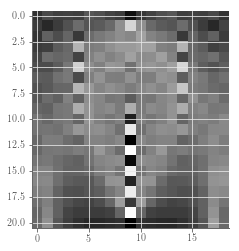

---- Curvature: 0.005 ----
Cylinder radius: 197.0
Road radius: 200.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 0.0149155429698
Processing: pitch -- 34.0, yaw -- 180.0
Score: 0.0159652042497
Processing: pitch -- 37.0, yaw -- 180.0
Score: 0.0165643077138
Processing: pitch -- 40.0, yaw -- 180.0
Score: 0.0184661980669
Processing: pitch -- 43.0, yaw -- 180.0
Score: 0.0196230492309
Processing: pitch -- 46.0, yaw -- 180.0
Score: 0.0200208934077
Processing: pitch -- 49.0, yaw -- 180.0
Score: 0.0186787362192
Processing: pitch -- 52.0, yaw -- 180.0
Score: 0.0198571459625
Processing: pitch -- 55.0, yaw -- 180.0
Score: 0.021823118382
Processing: pitch -- 58.0, yaw -- 180.0
Score: 0.0239792745116
Processing: pitch -- 61.0, yaw -- 180.0
Score: 0.0247338075328
Processing: pitch -- 64.0, yaw -- 180.0
Score: 0.0232780615636
Processing: pitch -- 67.0, yaw -- 180.0
Score: 0.0224986475295
Processing: pitch -- 70.0, yaw -- 180.0
Score: 0.0235892033999
Processing: pitch -- 73.0, yaw -- 180.0
Score: 0.0

Score: 0.0283600744997
Processing: pitch -- 58.0, yaw -- 240.0
Score: 0.0266402890883
Processing: pitch -- 61.0, yaw -- 240.0
Score: 0.0271628169565
Processing: pitch -- 64.0, yaw -- 240.0
Score: 0.0276263682617
Processing: pitch -- 67.0, yaw -- 240.0
Score: 0.0272782787088
Processing: pitch -- 70.0, yaw -- 240.0
Score: 0.0290929601632
Processing: pitch -- 73.0, yaw -- 240.0
Score: 0.0265906488658
Processing: pitch -- 76.0, yaw -- 240.0
Score: 0.0258689798463
Processing: pitch -- 79.0, yaw -- 240.0
Score: 0.0232475863842
Processing: pitch -- 82.0, yaw -- 240.0
Score: 0.0217375461073
Processing: pitch -- 85.0, yaw -- 240.0
Score: 0.0192870408838
Processing: pitch -- 88.0, yaw -- 240.0
Score: 0.0170805766326
Processing: pitch -- 91.0, yaw -- 240.0
Score: 0.014396476005
Processing: pitch -- 31.0, yaw -- 250.0
Score: 0.01857694208
Processing: pitch -- 34.0, yaw -- 250.0
Score: 0.0229997546808
Processing: pitch -- 37.0, yaw -- 250.0
Score: 0.0273957964911
Processing: pitch -- 40.0, yaw -- 2

Score: 0.0265906488658
Processing: pitch -- 76.0, yaw -- 300.0
Score: 0.0258689798463
Processing: pitch -- 79.0, yaw -- 300.0
Score: 0.0232475863842
Processing: pitch -- 82.0, yaw -- 300.0
Score: 0.0217375461073
Processing: pitch -- 85.0, yaw -- 300.0
Score: 0.0192870408838
Processing: pitch -- 88.0, yaw -- 300.0
Score: 0.0170805766326
Processing: pitch -- 91.0, yaw -- 300.0
Score: 0.014396476005
Processing: pitch -- 31.0, yaw -- 310.0
Score: 0.0217708675897
Processing: pitch -- 34.0, yaw -- 310.0
Score: 0.0198117618104
Processing: pitch -- 37.0, yaw -- 310.0
Score: 0.0259556105698
Processing: pitch -- 40.0, yaw -- 310.0
Score: 0.0237440424846
Processing: pitch -- 43.0, yaw -- 310.0
Score: 0.0289962027186
Processing: pitch -- 46.0, yaw -- 310.0
Score: 0.0287987783002
Processing: pitch -- 49.0, yaw -- 310.0
Score: 0.0297893977332
Processing: pitch -- 52.0, yaw -- 310.0
Score: 0.0300626620199
Processing: pitch -- 55.0, yaw -- 310.0
Score: 0.028463550597
Processing: pitch -- 58.0, yaw -- 

Score: 0.0227306767671


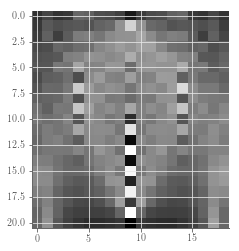

---- Curvature: 0.01 ----
Cylinder radius: 97.0
Road radius: 100.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 0.0130447887654
Processing: pitch -- 34.0, yaw -- 180.0
Score: 0.0132022997704
Processing: pitch -- 37.0, yaw -- 180.0
Score: 0.0139138959072
Processing: pitch -- 40.0, yaw -- 180.0
Score: 0.014785708497
Processing: pitch -- 43.0, yaw -- 180.0
Score: 0.0160733207629
Processing: pitch -- 46.0, yaw -- 180.0
Score: 0.0176282621082
Processing: pitch -- 49.0, yaw -- 180.0
Score: 0.0194790370903
Processing: pitch -- 52.0, yaw -- 180.0
Score: 0.0216418261928
Processing: pitch -- 55.0, yaw -- 180.0
Score: 0.02387827539
Processing: pitch -- 58.0, yaw -- 180.0
Score: 0.0243939179537
Processing: pitch -- 61.0, yaw -- 180.0
Score: 0.0227664256794
Processing: pitch -- 64.0, yaw -- 180.0
Score: 0.0217421930636
Processing: pitch -- 67.0, yaw -- 180.0
Score: 0.0225588900678
Processing: pitch -- 70.0, yaw -- 180.0
Score: 0.0247183535184
Processing: pitch -- 73.0, yaw -- 180.0
Score: 0.02710

Score: 0.0269831311549
Processing: pitch -- 46.0, yaw -- 240.0
Score: 0.0274479056279
Processing: pitch -- 49.0, yaw -- 240.0
Score: 0.0289506020409
Processing: pitch -- 52.0, yaw -- 240.0
Score: 0.0276427866529
Processing: pitch -- 55.0, yaw -- 240.0
Score: 0.0288000150016
Processing: pitch -- 58.0, yaw -- 240.0
Score: 0.0267230309749
Processing: pitch -- 61.0, yaw -- 240.0
Score: 0.0282371645645
Processing: pitch -- 64.0, yaw -- 240.0
Score: 0.0271143616715
Processing: pitch -- 67.0, yaw -- 240.0
Score: 0.0282582097842
Processing: pitch -- 70.0, yaw -- 240.0
Score: 0.0283516113029
Processing: pitch -- 73.0, yaw -- 240.0
Score: 0.0259484262937
Processing: pitch -- 76.0, yaw -- 240.0
Score: 0.0255156695823
Processing: pitch -- 79.0, yaw -- 240.0
Score: 0.0229067176951
Processing: pitch -- 82.0, yaw -- 240.0
Score: 0.0216378153806
Processing: pitch -- 85.0, yaw -- 240.0
Score: 0.019085594425
Processing: pitch -- 88.0, yaw -- 240.0
Score: 0.0170784621481
Processing: pitch -- 91.0, yaw --

Score: 0.0282582097842
Processing: pitch -- 70.0, yaw -- 300.0
Score: 0.0283516113029
Processing: pitch -- 73.0, yaw -- 300.0
Score: 0.0259484262937
Processing: pitch -- 76.0, yaw -- 300.0
Score: 0.0255156695823
Processing: pitch -- 79.0, yaw -- 300.0
Score: 0.0229067176951
Processing: pitch -- 82.0, yaw -- 300.0
Score: 0.0216378153806
Processing: pitch -- 85.0, yaw -- 300.0
Score: 0.019085594425
Processing: pitch -- 88.0, yaw -- 300.0
Score: 0.0170784621481
Processing: pitch -- 91.0, yaw -- 300.0
Score: 0.0142797941139
Processing: pitch -- 31.0, yaw -- 310.0
Score: 0.0162214990865
Processing: pitch -- 34.0, yaw -- 310.0
Score: 0.025047683515
Processing: pitch -- 37.0, yaw -- 310.0
Score: 0.0220009436278
Processing: pitch -- 40.0, yaw -- 310.0
Score: 0.0259690756759
Processing: pitch -- 43.0, yaw -- 310.0
Score: 0.029340400334
Processing: pitch -- 46.0, yaw -- 310.0
Score: 0.0277985509533
Processing: pitch -- 49.0, yaw -- 310.0
Score: 0.0331503671314
Processing: pitch -- 52.0, yaw -- 3

Score: 0.0219281962214


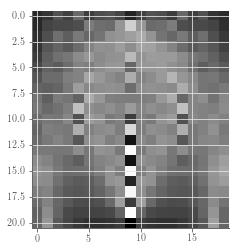

---- Curvature: 0.05 ----
Cylinder radius: 17.0
Road radius: 20.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 0.0153665490895
Processing: pitch -- 34.0, yaw -- 180.0
Score: 0.0154069681307
Processing: pitch -- 37.0, yaw -- 180.0
Score: 0.0208335415969
Processing: pitch -- 40.0, yaw -- 180.0
Score: 0.0189928485419
Processing: pitch -- 43.0, yaw -- 180.0
Score: 0.0229476484492
Processing: pitch -- 46.0, yaw -- 180.0
Score: 0.0227078657983
Processing: pitch -- 49.0, yaw -- 180.0
Score: 0.0236056323507
Processing: pitch -- 52.0, yaw -- 180.0
Score: 0.0268105936406
Processing: pitch -- 55.0, yaw -- 180.0
Score: 0.024941750363
Processing: pitch -- 58.0, yaw -- 180.0
Score: 0.0245927080626
Processing: pitch -- 61.0, yaw -- 180.0
Score: 0.0244890089881
Processing: pitch -- 64.0, yaw -- 180.0
Score: 0.0242100579112
Processing: pitch -- 67.0, yaw -- 180.0
Score: 0.0236802012529
Processing: pitch -- 70.0, yaw -- 180.0
Score: 0.0229560077711
Processing: pitch -- 73.0, yaw -- 180.0
Score: 0.0221

Score: 0.0301584514181
Processing: pitch -- 46.0, yaw -- 240.0
Score: 0.0261731980946
Processing: pitch -- 49.0, yaw -- 240.0
Score: 0.0315112229365
Processing: pitch -- 52.0, yaw -- 240.0
Score: 0.0307907034588
Processing: pitch -- 55.0, yaw -- 240.0
Score: 0.0289169329001
Processing: pitch -- 58.0, yaw -- 240.0
Score: 0.0297529846839
Processing: pitch -- 61.0, yaw -- 240.0
Score: 0.0250709703485
Processing: pitch -- 64.0, yaw -- 240.0
Score: 0.0289677673872
Processing: pitch -- 67.0, yaw -- 240.0
Score: 0.0249850990644
Processing: pitch -- 70.0, yaw -- 240.0
Score: 0.0260651771046
Processing: pitch -- 73.0, yaw -- 240.0
Score: 0.0233247916353
Processing: pitch -- 76.0, yaw -- 240.0
Score: 0.023819775172
Processing: pitch -- 79.0, yaw -- 240.0
Score: 0.0210651188577
Processing: pitch -- 82.0, yaw -- 240.0
Score: 0.020618623969
Processing: pitch -- 85.0, yaw -- 240.0
Score: 0.0178690586539
Processing: pitch -- 88.0, yaw -- 240.0
Score: 0.0169295374296
Processing: pitch -- 91.0, yaw -- 

Score: 0.0249850990644
Processing: pitch -- 70.0, yaw -- 300.0
Score: 0.0260651771046
Processing: pitch -- 73.0, yaw -- 300.0
Score: 0.0233247916353
Processing: pitch -- 76.0, yaw -- 300.0
Score: 0.023819775172
Processing: pitch -- 79.0, yaw -- 300.0
Score: 0.0210651188577
Processing: pitch -- 82.0, yaw -- 300.0
Score: 0.020618623969
Processing: pitch -- 85.0, yaw -- 300.0
Score: 0.0178690586539
Processing: pitch -- 88.0, yaw -- 300.0
Score: 0.0169295374296
Processing: pitch -- 91.0, yaw -- 300.0
Score: 0.0136009319139
Processing: pitch -- 31.0, yaw -- 310.0
Score: 0.0179418580166
Processing: pitch -- 34.0, yaw -- 310.0
Score: 0.0199138934482
Processing: pitch -- 37.0, yaw -- 310.0
Score: 0.0229029164866
Processing: pitch -- 40.0, yaw -- 310.0
Score: 0.0291373353962
Processing: pitch -- 43.0, yaw -- 310.0
Score: 0.0305589395553
Processing: pitch -- 46.0, yaw -- 310.0
Score: 0.0324053053109
Processing: pitch -- 49.0, yaw -- 310.0
Score: 0.0339216750662
Processing: pitch -- 52.0, yaw -- 

Score: 0.0213888599582


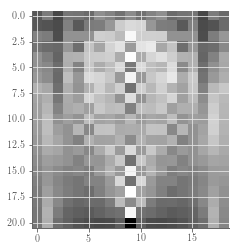

---- Curvature: 0.1 ----
Cylinder radius: 7.0
Road radius: 10.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 0.0102091583472
Processing: pitch -- 34.0, yaw -- 180.0
Score: 0.0129512591916
Processing: pitch -- 37.0, yaw -- 180.0
Score: 0.0149484979749
Processing: pitch -- 40.0, yaw -- 180.0
Score: 0.0155493297531
Processing: pitch -- 43.0, yaw -- 180.0
Score: 0.0159341243477
Processing: pitch -- 46.0, yaw -- 180.0
Score: 0.0158466643658
Processing: pitch -- 49.0, yaw -- 180.0
Score: 0.0156336841439
Processing: pitch -- 52.0, yaw -- 180.0
Score: 0.0161004902285
Processing: pitch -- 55.0, yaw -- 180.0
Score: 0.0160425096322
Processing: pitch -- 58.0, yaw -- 180.0
Score: 0.0168282626138
Processing: pitch -- 61.0, yaw -- 180.0
Score: 0.0175656944669
Processing: pitch -- 64.0, yaw -- 180.0
Score: 0.0182658316358
Processing: pitch -- 67.0, yaw -- 180.0
Score: 0.0194019557037
Processing: pitch -- 70.0, yaw -- 180.0
Score: 0.0203795336197
Processing: pitch -- 73.0, yaw -- 180.0
Score: 0.02138

Score: 0.025457408882
Processing: pitch -- 46.0, yaw -- 240.0
Score: 0.0258646141935
Processing: pitch -- 49.0, yaw -- 240.0
Score: 0.0255514148192
Processing: pitch -- 52.0, yaw -- 240.0
Score: 0.0263127969839
Processing: pitch -- 55.0, yaw -- 240.0
Score: 0.024729552194
Processing: pitch -- 58.0, yaw -- 240.0
Score: 0.0268360227601
Processing: pitch -- 61.0, yaw -- 240.0
Score: 0.0257603612643
Processing: pitch -- 64.0, yaw -- 240.0
Score: 0.0235097403894
Processing: pitch -- 67.0, yaw -- 240.0
Score: 0.0245438481172
Processing: pitch -- 70.0, yaw -- 240.0
Score: 0.0215208709847
Processing: pitch -- 73.0, yaw -- 240.0
Score: 0.0244992093096
Processing: pitch -- 76.0, yaw -- 240.0
Score: 0.0199404431849
Processing: pitch -- 79.0, yaw -- 240.0
Score: 0.0211550109645
Processing: pitch -- 82.0, yaw -- 240.0
Score: 0.0188793673842
Processing: pitch -- 85.0, yaw -- 240.0
Score: 0.0175051089969
Processing: pitch -- 88.0, yaw -- 240.0
Score: 0.0159275000292
Processing: pitch -- 91.0, yaw -- 

Score: 0.0257603612643
Processing: pitch -- 64.0, yaw -- 300.0
Score: 0.0235097403894
Processing: pitch -- 67.0, yaw -- 300.0
Score: 0.0245438481172
Processing: pitch -- 70.0, yaw -- 300.0
Score: 0.0215208709847
Processing: pitch -- 73.0, yaw -- 300.0
Score: 0.0244992093096
Processing: pitch -- 76.0, yaw -- 300.0
Score: 0.0199404431849
Processing: pitch -- 79.0, yaw -- 300.0
Score: 0.0211550109645
Processing: pitch -- 82.0, yaw -- 300.0
Score: 0.0188793673842
Processing: pitch -- 85.0, yaw -- 300.0
Score: 0.0175051089969
Processing: pitch -- 88.0, yaw -- 300.0
Score: 0.0159275000292
Processing: pitch -- 91.0, yaw -- 300.0
Score: 0.013671847523
Processing: pitch -- 31.0, yaw -- 310.0
Score: 0.0152663260634
Processing: pitch -- 34.0, yaw -- 310.0
Score: 0.0255022009584
Processing: pitch -- 37.0, yaw -- 310.0
Score: 0.0187943748943
Processing: pitch -- 40.0, yaw -- 310.0
Score: 0.029787333044
Processing: pitch -- 43.0, yaw -- 310.0
Score: 0.0238187207249
Processing: pitch -- 46.0, yaw -- 

Score: 0.0253053724095
Processing: pitch -- 79.0, yaw -- 360.0
Score: 0.025956820766
Processing: pitch -- 82.0, yaw -- 360.0
Score: 0.0261793802568
Processing: pitch -- 85.0, yaw -- 360.0
Score: 0.0260933791206
Processing: pitch -- 88.0, yaw -- 360.0
Score: 0.0257998307572
Processing: pitch -- 91.0, yaw -- 360.0
Score: 0.0253297577793


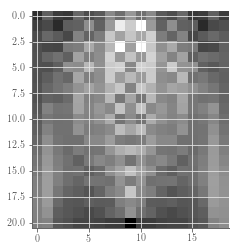

---- Curvature: 0.2 ----
Cylinder radius: 2.0
Road radius: 5.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 4.9030214666e-06
Processing: pitch -- 34.0, yaw -- 180.0
Score: 5.97037051891e-05
Processing: pitch -- 37.0, yaw -- 180.0
Score: 0.000393891289238
Processing: pitch -- 40.0, yaw -- 180.0
Score: 0.00150588899956
Processing: pitch -- 43.0, yaw -- 180.0
Score: 0.00379994084935
Processing: pitch -- 46.0, yaw -- 180.0
Score: 0.00701176024586
Processing: pitch -- 49.0, yaw -- 180.0
Score: 0.0103894462572
Processing: pitch -- 52.0, yaw -- 180.0
Score: 0.013035660949
Processing: pitch -- 55.0, yaw -- 180.0
Score: 0.0147541297137
Processing: pitch -- 58.0, yaw -- 180.0
Score: 0.0154830091427
Processing: pitch -- 61.0, yaw -- 180.0
Score: 0.015802586154
Processing: pitch -- 64.0, yaw -- 180.0
Score: 0.01598081487
Processing: pitch -- 67.0, yaw -- 180.0
Score: 0.0161725115722
Processing: pitch -- 70.0, yaw -- 180.0
Score: 0.0168210601401
Processing: pitch -- 73.0, yaw -- 180.0
Score: 0.01

Score: 0.0259475857595
Processing: pitch -- 46.0, yaw -- 240.0
Score: 0.0306252006467
Processing: pitch -- 49.0, yaw -- 240.0
Score: 0.0261728246752
Processing: pitch -- 52.0, yaw -- 240.0
Score: 0.030770499891
Processing: pitch -- 55.0, yaw -- 240.0
Score: 0.0262152635303
Processing: pitch -- 58.0, yaw -- 240.0
Score: 0.027376384847
Processing: pitch -- 61.0, yaw -- 240.0
Score: 0.0243974395723
Processing: pitch -- 64.0, yaw -- 240.0
Score: 0.0278098134721
Processing: pitch -- 67.0, yaw -- 240.0
Score: 0.0225541992798
Processing: pitch -- 70.0, yaw -- 240.0
Score: 0.0238711220768
Processing: pitch -- 73.0, yaw -- 240.0
Score: 0.020289515875
Processing: pitch -- 76.0, yaw -- 240.0
Score: 0.0196099736166
Processing: pitch -- 79.0, yaw -- 240.0
Score: 0.0186177412135
Processing: pitch -- 82.0, yaw -- 240.0
Score: 0.0174963930138
Processing: pitch -- 85.0, yaw -- 240.0
Score: 0.0174200209012
Processing: pitch -- 88.0, yaw -- 240.0
Score: 0.0139604126217
Processing: pitch -- 91.0, yaw -- 2

Score: 0.0225541992798
Processing: pitch -- 70.0, yaw -- 300.0
Score: 0.0238711220768
Processing: pitch -- 73.0, yaw -- 300.0
Score: 0.020289515875
Processing: pitch -- 76.0, yaw -- 300.0
Score: 0.0196099736166
Processing: pitch -- 79.0, yaw -- 300.0
Score: 0.0186177412135
Processing: pitch -- 82.0, yaw -- 300.0
Score: 0.0174963930138
Processing: pitch -- 85.0, yaw -- 300.0
Score: 0.0174200209012
Processing: pitch -- 88.0, yaw -- 300.0
Score: 0.0139604126217
Processing: pitch -- 91.0, yaw -- 300.0
Score: 0.0142104880315
Processing: pitch -- 31.0, yaw -- 310.0
Score: 0.0121083286419
Processing: pitch -- 34.0, yaw -- 310.0
Score: 0.0167814119743
Processing: pitch -- 37.0, yaw -- 310.0
Score: 0.0169508359593
Processing: pitch -- 40.0, yaw -- 310.0
Score: 0.0226141004692
Processing: pitch -- 43.0, yaw -- 310.0
Score: 0.024303732475
Processing: pitch -- 46.0, yaw -- 310.0
Score: 0.0275400681235
Processing: pitch -- 49.0, yaw -- 310.0
Score: 0.0248542278541
Processing: pitch -- 52.0, yaw -- 

Score: 0.0210823910389
Processing: pitch -- 88.0, yaw -- 360.0
Score: 0.021137456077
Processing: pitch -- 91.0, yaw -- 360.0
Score: 0.0211155403371


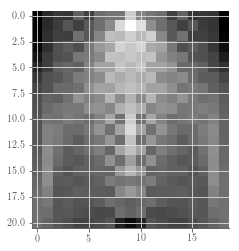

---- Curvature: 0.3 ----
Cylinder radius: 0.333333333333
Road radius: 3.33333333333
Processing: pitch -- 31.0, yaw -- 180.0
Score: 4.01819122155e-10
Processing: pitch -- 34.0, yaw -- 180.0
Score: 1.01874259362e-07
Processing: pitch -- 37.0, yaw -- 180.0
Score: 4.37981483581e-06
Processing: pitch -- 40.0, yaw -- 180.0
Score: 5.94991593676e-05
Processing: pitch -- 43.0, yaw -- 180.0
Score: 0.000413081218374
Processing: pitch -- 46.0, yaw -- 180.0
Score: 0.00164540498987
Processing: pitch -- 49.0, yaw -- 180.0
Score: 0.00412925019832
Processing: pitch -- 52.0, yaw -- 180.0
Score: 0.00736227138373
Processing: pitch -- 55.0, yaw -- 180.0
Score: 0.0103545237836
Processing: pitch -- 58.0, yaw -- 180.0
Score: 0.0124122942482
Processing: pitch -- 61.0, yaw -- 180.0
Score: 0.0135048596691
Processing: pitch -- 64.0, yaw -- 180.0
Score: 0.0141076211483
Processing: pitch -- 67.0, yaw -- 180.0
Score: 0.0143677276704
Processing: pitch -- 70.0, yaw -- 180.0
Score: 0.0150668860173
Processing: pitch -- 

Score: 0.0295565864417
Processing: pitch -- 52.0, yaw -- 240.0
Score: 0.0235344350129
Processing: pitch -- 55.0, yaw -- 240.0
Score: 0.0293533663351
Processing: pitch -- 58.0, yaw -- 240.0
Score: 0.0243586066637
Processing: pitch -- 61.0, yaw -- 240.0
Score: 0.0274991015523
Processing: pitch -- 64.0, yaw -- 240.0
Score: 0.0248771737613
Processing: pitch -- 67.0, yaw -- 240.0
Score: 0.0223220166513
Processing: pitch -- 70.0, yaw -- 240.0
Score: 0.0253687084335
Processing: pitch -- 73.0, yaw -- 240.0
Score: 0.0180673100792
Processing: pitch -- 76.0, yaw -- 240.0
Score: 0.0227884582354
Processing: pitch -- 79.0, yaw -- 240.0
Score: 0.0162993638972
Processing: pitch -- 82.0, yaw -- 240.0
Score: 0.0187421751573
Processing: pitch -- 85.0, yaw -- 240.0
Score: 0.0143013738503
Processing: pitch -- 88.0, yaw -- 240.0
Score: 0.0158851761215
Processing: pitch -- 91.0, yaw -- 240.0
Score: 0.011710293787
Processing: pitch -- 31.0, yaw -- 250.0
Score: 0.0153197864934
Processing: pitch -- 34.0, yaw --

Score: 0.0253687084335
Processing: pitch -- 73.0, yaw -- 300.0
Score: 0.0180673100792
Processing: pitch -- 76.0, yaw -- 300.0
Score: 0.0227884582354
Processing: pitch -- 79.0, yaw -- 300.0
Score: 0.0162993638972
Processing: pitch -- 82.0, yaw -- 300.0
Score: 0.0187421751573
Processing: pitch -- 85.0, yaw -- 300.0
Score: 0.0143013738503
Processing: pitch -- 88.0, yaw -- 300.0
Score: 0.0158851761215
Processing: pitch -- 91.0, yaw -- 300.0
Score: 0.011710293787
Processing: pitch -- 31.0, yaw -- 310.0
Score: 0.0229715272849
Processing: pitch -- 34.0, yaw -- 310.0
Score: 0.0151263116452
Processing: pitch -- 37.0, yaw -- 310.0
Score: 0.0271905603644
Processing: pitch -- 40.0, yaw -- 310.0
Score: 0.0204801460598
Processing: pitch -- 43.0, yaw -- 310.0
Score: 0.0330882413151
Processing: pitch -- 46.0, yaw -- 310.0
Score: 0.0252952245055
Processing: pitch -- 49.0, yaw -- 310.0
Score: 0.0301098769978
Processing: pitch -- 52.0, yaw -- 310.0
Score: 0.0261408848388
Processing: pitch -- 55.0, yaw --

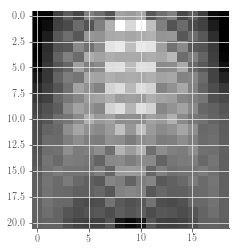

In [16]:
for curvature in curvatures:
    print("---- Curvature: {0} ----".format(curvature))
    camera_height = 6.0
    resolution = (10, 10) # use same resolution for all
    fov_deg = (60.0, 60.0)
    yaw_range = 90 # degrees +- from center yaw position

    length = 2*np.pi/curvature # 1 full revolution

    path = Path()
    path.add_segment(curvature, length)
    road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

    # place camera halfway along road
    allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
    lhs_pos, lhs_direction = allowed_positions_orientations[0]
    rhs_pos, rhs_direction = allowed_positions_orientations[1]

    #TODO figure out which one is LHS versus RHS for positive curvature...
    # ====> the first element (lhs here) is OUT ie. away from center of curvature
    # ====> LHS is good for first tests of outside
    
    camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
    camera_pitches = np.arange(31.0, 92.0, 3)

    # convert lhs_direction into a yaw facing the road perpendicularly
    center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
    center_yaw_deg = np.rad2deg(center_yaw_rad) + 180 # TODO figure out automatically if the +180 is required
    camera_yaws = np.arange(center_yaw_deg - yaw_range, center_yaw_deg + yaw_range + 10, 10.0)
    
    # cylinder charactistics
    road_pt = road.path.get_point_at(length/2.0)
    road_normal = road.path.get_normal_at(length/2.0)
    road_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0))
    cylinder_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0)) 
    cylinder_radius -= road.halfwidth 
    cylinder_radius -= road.side_offset
    cylinder_center = road_pt + road_normal * road_radius
    cylinder_direction = np.array([0.0, 0.0, 1.0])
    
    x_unit, y_unit = np.array([1.0,0,0]), np.array([0.0, 1.0, 0.0])
    
    path_points = []
    for d in np.arange(0, length, 0.5):
        path_points.append(road.path.get_point_at(d))
    path_points = np.array(path_points)
    
    
    print("Cylinder radius: {0}".format(cylinder_radius))
    print("Road radius: {0}".format(1/road.path.get_curvature_at(length/2.0)))

    scores = np.zeros(shape=(camera_pitches.shape[0], camera_yaws.shape[0]))
    for j, yaw in enumerate(camera_yaws):
        for i, pitch in enumerate(camera_pitches):
            print("Processing: pitch -- {0}, yaw -- {1}".format(pitch, yaw))
            name = "pitch_{0}_yaw_{1}".format(pitch, yaw)
            camera = Camera(camera_position, pitch, yaw)
            camera.set_resolution(*resolution)
            camera.set_fov(*fov_deg)
            # set edge boundary for visual obstruction
            camera.attach_cylinder(cylinder_center, cylinder_direction, cylinder_radius)

            pixel_probabilities = camera.get_pixel_probabilities_for_road(road)

            # didn't want any pyplot stuff running
            # in case of leaking memory from open figures that I don't quite understand

#             plt.imshow(np.flip(pixel_probabilities, 0))
#             plt.gray()
#             plt.show()
            
#             fig = plt.figure()
#             ax = fig.add_subplot(111, projection='3d')
#             ax.view_init(elev=10., azim=0.0)
#             plot_vector(ax, camera.position, camera.position+camera.orientation_vector)
#             corners = camera.get_corners()
#             corners = np.array([x for x in corners if x is not None])
#             plot_points(ax, corners)
#             plot_points(ax, path_points)
#             plot_vector(ax, cylinder_center, cylinder_center + cylinder_direction)
#             plot_vector(ax, cylinder_center, cylinder_center+x_unit*cylinder_radius)
#             plot_vector(ax, cylinder_center, cylinder_center+y_unit*cylinder_radius)
#             plt.show()
            



            # calculate error radius at each pixel
            error_bounds = error_radius_across_pixels(camera)
    #         plt.imshow(error_bounds)
    #         plt.gray()
    #         plt.imsave(save_dir + name + "_error_bounds.png")

            target = (1.0/(1+error_bounds)) * pixel_probabilities
    #         plt.imshow(product)
    #         plt.gray()
    #         plt.imsave(save_dir + name + "_product.png")
            # take the sum => now have an expected value!

            score = np.sum(target)
            print("Score: {0}".format(score))
            scores[i, j] = score
    plt.imshow(scores)
    plt.gray()
    plt.show()
    curvature_score_maps.append(scores)

In [20]:
curvature_score_maps = np.array(curvature_score_maps)
np.save("curved_roads_{0}x{1}_6m-4_two_stddev.npy".format(*resolution), curvature_score_maps)


In [15]:
n_pitch = 21
n_yaw = 19
# if lost expensive computation again... can use printed strings to recover data
def string_to_scores(raw_str, n_pitch, n_yaw, pitch_axis_first=True):
    data = raw_str.split('\n')
    recovered = []
    for x in data:
        if 'Score' in x:
            recovered.append(float(x.split(':')[1].strip()))
    
    scores = np.array(recovered)
    if pitch_axis_first:
        # ie. the first axis printed was pitch
        scores = scores.reshape(n_pitch, n_yaw).T
    else:
        scores = scores.reshape(n_pitch, n_yaw)
    return scores

In [31]:
# --- resoume from saved maps ---
curvature_score_maps = np.load("curved_roads_{0}x{1}_6m-4_two_stddev.npy".format(*(300,300)))


Curvature: 0.001, Radius: 1000.0, Circumference: 6283.18530718


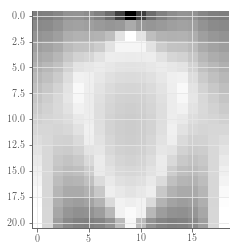

Curvature: 0.005, Radius: 200.0, Circumference: 1256.63706144


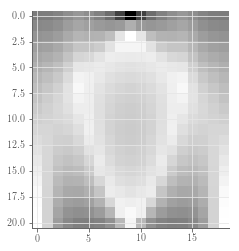

Curvature: 0.01, Radius: 100.0, Circumference: 628.318530718


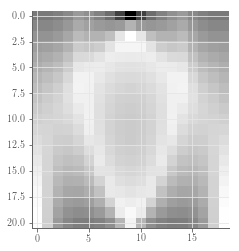

Curvature: 0.05, Radius: 20.0, Circumference: 125.663706144


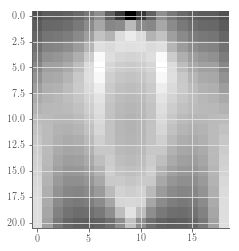

Curvature: 0.1, Radius: 10.0, Circumference: 62.8318530718


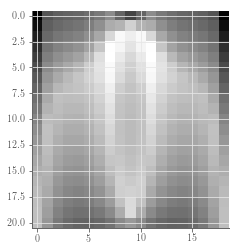

Curvature: 0.2, Radius: 5.0, Circumference: 31.4159265359


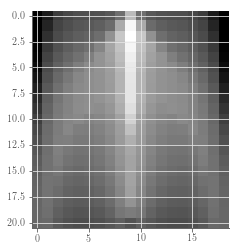

Curvature: 0.3, Radius: 3.33333333333, Circumference: 20.9439510239


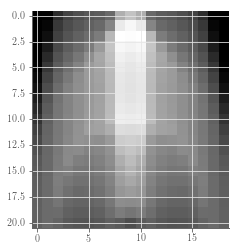

In [34]:
for i, score_map in enumerate(curvature_score_maps):
    print("Curvature: {0}, Radius: {1}, Circumference: {2}".format(curvatures[i], 1.0/curvatures[i], 2*np.pi/curvatures[i]))
    plt.imshow(score_map)
    plt.gray()
    plt.show()

In [19]:
# get sorted indices
sorted_indices = np.array(np.unravel_index(np.argsort(scores, axis=None), scores.shape)).T
print(sorted_indices)

[[ 0  0]
 [ 0 18]
 [ 1  0]
 [ 1 18]
 [ 2  0]
 [ 2 18]
 [ 3  0]
 [ 3 18]
 [ 4  0]
 [ 4 18]
 [ 0  1]
 [ 0 17]
 [ 5  0]
 [ 5 18]
 [ 1  1]
 [ 1 17]
 [ 6  0]
 [ 6 18]
 [ 2  1]
 [ 2 17]
 [ 7  0]
 [ 7 18]
 [ 8  0]
 [ 8 18]
 [ 3  1]
 [ 3 17]
 [ 9  0]
 [ 9 18]
 [ 4  1]
 [ 4 17]
 [ 0  2]
 [ 0 16]
 [10  0]
 [10 18]
 [ 5  1]
 [ 5 17]
 [ 1  2]
 [ 1 16]
 [11  0]
 [11 18]
 [ 2  2]
 [ 2 16]
 [ 6  1]
 [ 6 17]
 [ 0  3]
 [ 0 15]
 [12  0]
 [12 18]
 [ 3  2]
 [ 3 16]
 [ 1  3]
 [ 1 15]
 [ 7  1]
 [ 7 17]
 [20  9]
 [ 0  4]
 [ 0 14]
 [13  0]
 [13 18]
 [ 4  2]
 [ 4 16]
 [ 2  3]
 [ 2 15]
 [20 13]
 [20  5]
 [20 14]
 [20  4]
 [ 8  1]
 [ 8 17]
 [ 1  4]
 [ 1 14]
 [14  0]
 [14 18]
 [ 0  5]
 [ 0 13]
 [20  6]
 [20 12]
 [20  3]
 [20 15]
 [20 10]
 [20  8]
 [15  0]
 [15 18]
 [ 0  6]
 [ 0 12]
 [ 9  1]
 [ 9 17]
 [ 5  2]
 [ 5 16]
 [19 14]
 [19  4]
 [ 3  3]
 [ 3 15]
 [19 13]
 [19  5]
 [16  0]
 [16 18]
 [17  0]
 [17 18]
 [18  0]
 [18 18]
 [ 2  4]
 [ 2 14]
 [19  0]
 [19 18]
 [20  0]
 [20 18]
 [19 15]
 [19  3]
 [10  1]
 [10 17]
 